In [1]:
import pandas as pd
import numpy
from pandas import datetime
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

<ipython-input-1-e2418a6aa5a0>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
def parser(x):
   return datetime.strptime(x,'%d-%m-%Y')

df = pd.read_csv("./data/set.csv",index_col=0,parse_dates=[0],header=0,squeeze=True, date_parser=parser)
series=df[df['item']==1]
series=series.drop('item',axis=1)


In [26]:
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
def test_stationarity(timeseries, window = 12, cutoff = 0.01,count=0):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    
    #Perform Dickey-Fuller test:
    print('Performing Dickey-Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue >= cutoff:
        count+=1
        print("\n\ndifferentiating\n")
        first_diff = series.sales - series.sales.shift(1)
        first_diff = first_diff.dropna(inplace = False)
        test_stationarity(first_diff, window = 12)
        
        fig = pyplot.figure(figsize=(12,8))
        ax1 = fig.add_subplot(211)
        fig = sm.graphics.tsa.plot_acf(first_diff, lags=30, ax=ax1) # 
        ax2 = fig.add_subplot(212)
        fig = sm.graphics.tsa.plot_pacf(first_diff, lags=30, ax=ax2)# , lags=40
        
    return(count)
    
    
        
    

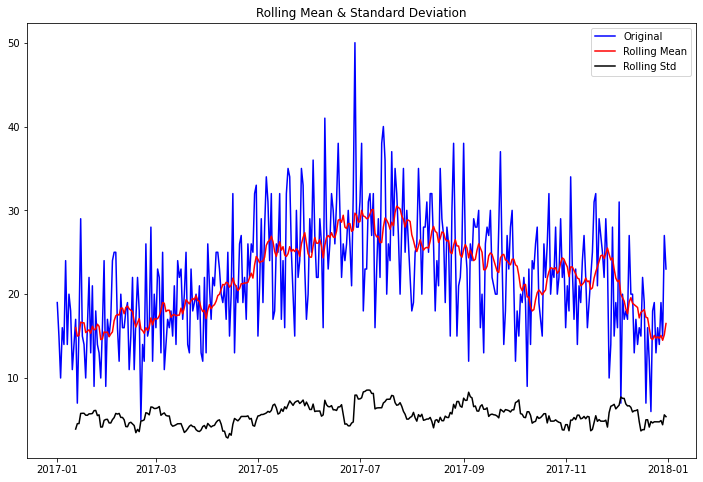

Performing Dickey-Fuller Test


differentiating



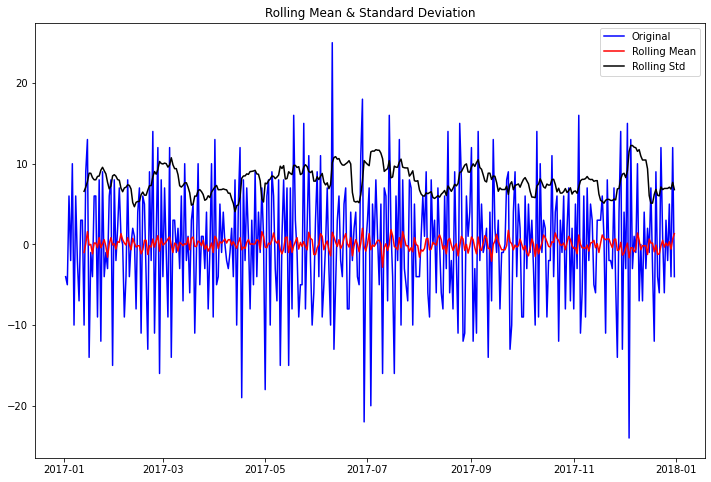

Performing Dickey-Fuller Test

I = 1

-----------------------------------------------------------------------------------------------

ACF and PACF:



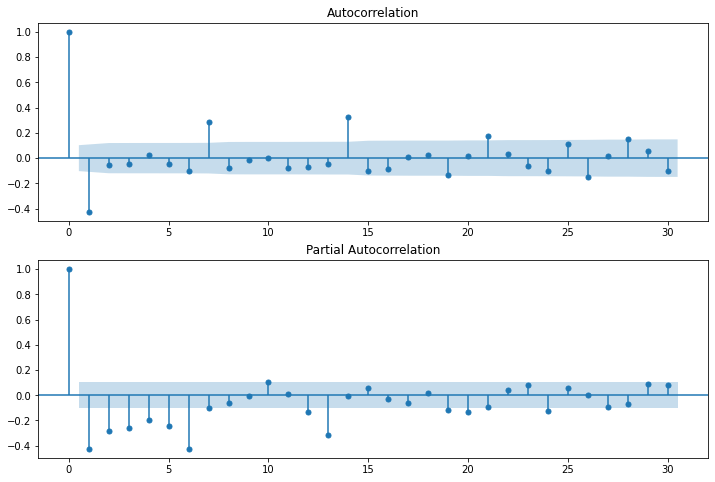

In [29]:
i=test_stationarity(series['sales'])
print("\nI =",i)
print("\n-----------------------------------------------------------------------------------------------\n")
print("ACF and PACF:\n")

In [30]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

predicted=680, expected=652
predicted=666, expected=674
predicted=650, expected=650
predicted=325, expected=321
Test MSE: 28.707


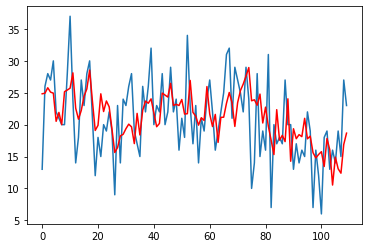

In [43]:
sum_p=0
sum_e=0
c=0
X = series.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = sm.tsa.statespace.SARIMAX(history, trend='n', order=(6,i,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%d, expected=%d' % (yhat, obs))
    sum_p+=yhat
    sum_e+=obs
    c+=1
    if c==30:
        print('predicted=%d, expected=%d' % (sum_p, sum_e))
        c=0
        sum_p=0
        sum_e=0
print('predicted=%d, expected=%d' % (sum_p, sum_e))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
#plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [44]:
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)

start_index = len(differenced)
end_index = start_index + 6
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print('Day %d: %d' % (day, inverted))
    history.append(inverted)
    day += 1

Day 1: 19
Day 2: 33
Day 3: 26
Day 4: 29
Day 5: 29
Day 6: 38
Day 7: 31
